In [2]:
import asyncio
import logging
import os
import time

import pickle
import vector; vector.register_awkward() 
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

import pandas as pd



In [3]:
DATA = "DoubleMuon"
NTUPLES = "data/ntuples.json"

## input files per process, set to e.g. 10 (smaller number = faster)
##-1 means use them all
N_FILES_MAX_PER_SAMPLE = 2

## BENCHMARKING-SPECIFIC SETTINGS

## chunk size to use
CHUNKSIZE = 500_000

## metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

## scaling for local setups with FuturesExecutor
NUM_CORES = 4


In [4]:

##NanoAOD datasets are stored in data/ntuples_nanoaod.json folder. 
##This json file contains information about the number of events, 
##process and systematic. The following function reads the 
##json file and returns a dictionary with the process to run.
#--------------------------------------------------
def construct_fileset(n_files_max_per_sample,
                      dataset="DoubleMuon",
                      onlyNominal=False,
                      ntuples_json=NTUPLES):
    ## Cross sections are in pb
    ## These numbers have been artificially manipulated
    ## to make the example plot coincide
    ## Xsections need to be correct and the backgrounds
    ## properly normalized
    xsec_info = {
    #    "ttbar": 831., 
    #    "wjets": 61526, 
    #    "tttt" : 0.009, 
    #    "dyjets": 6025,
    #    "ttbar": 831./200., 
        "TT4": 88.29, 
        "GGZH" : 0.00784, 
        "DYJETS": 5343.0*1.23,
        "data": None
    }

    ## list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)
    
    ## process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            file_list = file_info[process][dataset]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples

            file_paths = [f["path"] for f in file_list]
            metadata = {"process": "data", "xsec": 1}
            fileset.update({"data": {"files": file_paths, "metadata": metadata}})
            
        ##these "variations" are used for systematic studies
        ##A simple example would use only "nominal"
        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            #print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample] #use partial set

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

    return fileset
#--------------------------------------------------    



In [5]:


##-------------Build the filesets
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, dataset=DATA,
                            onlyNominal=True, ntuples_json=NTUPLES) 
##informational printouts
#print(fileset["ttbar__nominal"]["metadata"])
print(fileset["GGZH__nominal"]["metadata"])
print(fileset["TT4__nominal"]["metadata"])
print(fileset["DYJETS__nominal"]["metadata"])
print(fileset["data"]["metadata"])
print(f"\nExample information in fileset:\n{{\n  'files': [{fileset['data']['files'][:]}]\n")
##----------------------------------------------------------


{'process': 'GGZH', 'variation': 'nominal', 'nevts': 76000, 'xsec': 0.00784}
{'process': 'TT4', 'variation': 'nominal', 'nevts': 454000, 'xsec': 88.29}
{'process': 'DYJETS', 'variation': 'nominal', 'nevts': 2610309, 'xsec': 6571.89}
{'process': 'data', 'xsec': 1}

Example information in fileset:
{
  'files': [['file:data/2631F9B1-3B3E-7E4A-BE75-FC57E322C981.root', 'file:data/26A77DF8-54A5-7B44-B1BB-5B93CFF5C9C6.root']]



In [6]:
##---------------------------------------------------------
## This part is useful to check the total number of
## data events.  We will need to scale things properly later
## Load the JSON file
with open(NTUPLES, 'r') as file:
    data = json.load(file)
    #print(type(data))

## Initialize a variable to store the total number of events
total_events = 0

In [7]:
## Loop through the files in the JSON data
for file_info in data['data']['DoubleMuon']['files']:
    file_path = file_info['path']
    #print(file_path)

    ## Open the ROOT file using uproot
    with uproot.open(file_path) as f:
        ## Access the 'events' TTree and count the number of entries (events)
        num_events = f['Events'].num_entries

        ## Print the file path and number of events
        print("Real data dataset info:")
        print(f"File: {file_path}, Number of Events: {num_events}")

        ## Add the number of events to the total
        total_events += num_events

## Print the total number of events
print(f"Total Number of Events: {total_events}\n")
#-----------------------------------

Real data dataset info:
File: file:data/2631F9B1-3B3E-7E4A-BE75-FC57E322C981.root, Number of Events: 1477455
Real data dataset info:
File: file:data/26A77DF8-54A5-7B44-B1BB-5B93CFF5C9C6.root, Number of Events: 1659527
Total Number of Events: 3136982



In [8]:
##------------------------------------------------------Analyzer
##Here is the main analyzer. Uses coffea/awkward to make the analysis.
class TemplateAnalysis(processor.ProcessorABC):
    def __init__(self, DATASET):
        self.DATASET = DATASET
        # booking histograms
        # define categories
        # Take a look at 
        # https://cms-opendata-workshop.github.io/workshop2023-lesson-ttbarljetsanalysis/03-coffea-analysis/index.html#histogramming-and-plotting
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        ## define bins (axis)
        pt_axis = hist.axis.Regular( bins=500, start=0, stop=500, name="var")
        eta_axis = hist.axis.Regular( bins=40, start=-5, stop=5, name="var")
        phi_axis = hist.axis.Regular( bins=40, start=-4, stop=4, name="var")
        num_axis = hist.axis.Regular( bins=20, start=0, stop=20, name="var")
        R_axis = hist.axis.Regular( bins=20, start=0, stop=8, name="var")
        mass_axis = hist.axis.Regular( bins=20, start=0, stop=150, name="var")
        
        # define a dictionary of histograms
        # here is an example of a few variables that one might want to save for later and produce pretty plots
        # this, and most of the stuff here, will have to be tailored to the specifics of each analysis 
        self.hist_muon_dict = {
            #'muon_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'muon_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'nmuons'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_phi' : (hist.Hist(phi_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'njets'    : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())), 
            'nbjets'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_R' : (hist.Hist(R_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_mass' : (hist.Hist(mass_axis, process_cat, variation_cat, storage=hist.storage.Weight()))

        }
        
        # I think this might have to go
        # In principle sumw comes from ROOT's sumw(sum weight) function, but I do not know what it does here.
        sumw_dict = {'sumw': processor.defaultdict_accumulator(float)
        }
         
        
        ### define vector lists for scatter plot
        self.njets_signal_data = []
        self.njets_background_data = []
        self.nbjets_signal_data = []
        self.nbjets_background_data = []
        self.njets_values=[]
        self.nbjets_values=[]
        self.njets_data = []
        self.nbjets_data = []

    #------This process function is the one that
    # is run when the object of this class are forced to "run"
    def process(self, events):
        hists = self.hist_muon_dict.copy()
        # this refers to the type of dataset.  Do not confuse the process variable
        # here, with the name of the function:
        process = events.metadata["process"]
        #print(events.fields)

        #print(f'Working on process: {process}')
        #print(f'The dataset is {events.metadata["dataset"]}')
  
        if process != "data":
            # normalization for MC
            x_sec = events.metadata["xsec"]
            nevts_total = events.metadata["nevts"]
            # the luminosity has to be calculated and scaled appropiately
            # this number is hardcoded here
            lumi = 7.653261227*1000*3136982/45235604 # /pb integrated luminosity
            xsec_weight = x_sec * lumi / nevts_total #L*cross-section/N
        else:
            xsec_weight = 1


        #------------------Event Selection
        # Filtering of the data can be done essentially at two levels:
        # at the event level and the physical object level
        # Here are a few lines (mostly commented out) showcasing how one
        # could apply event selection requirements.
        # There could be a lot more event selection cuts that need to 
        # be applied, depending on the analysis
        
        #Require that the primary vertex in the event is good
        #primary_vertex= events.PV.npvsGood == True
        
        ## Requirement on number of primary vertex.
        ## Require at least one
        # 4 grados de libertad
        #a radial position within 2 cm of the beamspot axis
        
        primary_vertex = (events.PV.npvs >= 1) & (events.PV.z <= 24) & (np.sqrt(events.PV.x**2 + events.PV.y**2) <= 2) & (events.PV.ndof > 4)
        
        
        ##Trigger selection        
        #event_filters = ( events.HLT.IsoMu20 == 1 )
        
        #update event_filters container
        #event_filters = event_filters & primary_vertex
        event_filters=primary_vertex
        selected_events = events[event_filters]
        #--------------------------------------------------------------------------


        ##---------------------------------------Object selection
        ## This is selection that applies to specific physics objects, like muons, jets, b-jets, etc.
        ## Here are a few examples, mostly commented out for the sake of getting some statistics
        ## from a very low number of events.

        ## Note the use of masks in order to apply certain requirements
        #muon_is_global= events.Muon.isGlobal == True
        #muon_is_tracker= events.Muon.isTracker == True
        
        ## Note that this could be all replaced by Tight, Medium or Loose flags, that should be
        ## operative in 2016 nanoado production
        ## we have reduced the requirements just to get more events
        ## The selection, however, needs to align to what the papers describe for the corresponding analysis
        #loose_muon_selection = (events.Muon.pt > 10) & (abs(events.Muon.eta)<2.5) \
        #                        & ((muon_is_global) | (muon_is_tracker)) \
        #                        & (events.Muon.pfRelIso04_all < 0.25)
        # selected_muon_selection = (events.Muon.pt > 26) & (abs(events.Muon.eta)<2.1) \
        #                             & ((muon_is_global) & (muon_is_tracker)) \
        #                             & (events.Muon.nTrackerLayers > 5) & (events.Muon.nStations > 0) \
        #                             & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 0.5) \
        #                             & (events.Muon.pfRelIso04_all < .15)
        ## Note that the selection is done using the masks above
        ## This is how filtering is done in the industry as well
        #selected_muons = events.Muon[( loose_muon_selection & selected_muon_selection)]
        #veto_muons = events.Muon[( loose_muon_selection & ~selected_muon_selection)]
        #selected_muons = events.Muon[(events.Muon.pt > 5)]
        #selected_muon = (ak.count(selected_muons.pt, axis=1) == 1 ) 

        
        ## Selection of jets
        
        #jet_selection = (ak.count(jets_selection.pt, axis=1) == 1 )
        #selected_jets = events.Jet[jet_selection]
        ## Note here that some functions and tools are already implemented as part of coffea, like the TLorentzVector's nearest()
        ## See: https://github.com/CoffeaTeam/coffea/blob/d3beaff974025aa260efb2df9e8da7138a77b795/src/coffea/nanoevents/methods/vector.py#L779
        ## and the coffea documentation
        #nearest_lepton = selected_jets.nearest(selected_muons, threshold=.4)
        #selected_jets = selected_jets[ ~ak.is_none(nearest_lepton) ]
        ## the results of these 2 lines should be equivalent to the 2 lines above
        #lepton_mask = ak.any(selected_jets.metric_table(selected_lepton, metric=lambda j, e: ak.local_index(j, axis=1) == e.jetIdx,), axis=2)
        #selected_jets = selected_jets[~lepton_mask]
        ##this is an example of how b-jets might be selected
        #selected_bjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & (events.Jet.btagCSVV2 >=0.8)]
        #selected_jets_nobjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & ~(events.Jet.btagCSVV2 >=0.8)]
    
        jets_selection = (events.Jet.pt > 20) & (abs(events.Jet.eta) < 2.5) & (events.Jet.jetId > 1)
        
        #selected_jets = events.Jet[(jets_selection)]
        #selected_jet=(ak.count(selected_jets.pt, axis=1) == 1 )
        
        ##btag filtro    
        #selected_bjets = events.Jet[jets_selection & (events.Jet.btagCSVV2 >=0.8)]
        selected_bjets = events.Jet[jets_selection]
        #selected_bjet=(ak.count(selected_bjets.pt, axis=1) == 1 )
        
        ## Electron selection
        ##Veto electrons 
        #veto_electron_selection = (events.Electron.pt > 15) & (abs(events.Electron.eta) < 2.5) & (events.Electron.cutBased == 1)    
        ##tight electrons
        #selected_electron_selection = (events.Electron.pt > 30) & (abs(events.Electron.eta) < 2.1) & (events.Electron.cutBased == 4)
        #selected_electrons = events.Electron[ selected_electron_selection & veto_electron_selection]
        #veto_electrons = events.Electron[ veto_electron_selection ]
        #selected_electrons = events.Electron[(events.Electron.pt > 3)]        
        
        ## Additional selection
        ## Exactly zero additional loose muons
        #veto_muon = (ak.count(veto_muons.pt, axis=1 ) == 0 )
        #event_filters = event_filters & veto_muon
        ##Exactly zero veto electrons
        #veto_electron = (ak.count(veto_electrons.pt, axis=1) == 0 )      
        #event_filters = event_filters & veto_electron
        ## At least 6 jets
        #at_least_one_jet = (ak.count(selected_jets.pt, axis=1) >= 6)
        #event_filters = event_filters & at_least_one_jet
        
        ## At least 2 bjets
        selected_bjet = (ak.count(selected_bjets.pt, axis=1) >= 2)        
        event_filters = event_filters & selected_bjet
        #print(event_filters)
        
        ##overwrite the event filter just to get
        ##more statistics
        #event_filters = selected_bjet
        selected_events = events[event_filters]
        #selected_muons = selected_muons[event_filters]
        
        #selected_jets = selected_jets[event_filters]
        selected_bjets = selected_bjets[event_filters]
        
        #selected_electrons = selected_electrons[event_filters]
               
        
        
        #--------------------------------------------------------------------------


        ##------------------Hardest and Second hardest bjet
        
        
        ##Separating hardest and second hardest
        #Hardest
        
        
        selected_bjets = selected_bjets[:,0]
        
        #Second Hardest
        #selected_bjets = selected_bjets[:,1]

        
        
        
        
        ##filling of the histograms with weights       
        for ivar in [ "pt", "eta","phi" ]:
            #hists[f'muon_{ivar}'].fill(
            #            var=ak.flatten(getattr(selected_muons, ivar)), process=process, variation="nominal", weight=xsec_weight)
            hists[f'jets_{ivar}'].fill(
                        var=(getattr(selected_bjets, ivar)), process=process, variation="nominal", weight=xsec_weight)
            #hists['nmuons'].fill(var=ak.count(selected_muons.pt, axis=1), process=process, variation="nominal", weight=xsec_weight)
            #hists['njets'].fill(var=ak.count(selected_jets.pt, axis=0), process=process, variation="nominal", weight=xsec_weight)
            hists['nbjets'].fill(var=ak.count(selected_bjets.pt, axis=0), process=process,variation="nominal", weight=xsec_weight)
            
            #njets_values = ak.count(selected_jets.pt, axis=0)
            nbjets_values=ak.count(selected_bjets.pt, axis=0)
            
            #if process == "GGZH":
                #self.njets_signal_data.extend(njets_values)
            #    self.nbjets_signal_data.extend(nbjets_values)
                
            #elif process == "ttbar" or process == "TT4" or process == "DYJETS":
                #self.njets_background_data.extend(njets_values)
             #   self.nbjets_background_data.extend(nbjets_values)
                
            #elif process == "data":
                #self.njets_data.extend(njets_values)
            #   self.nbjets_data.extend(nbjets_values)
                
            output = {"nevents": {events.metadata["dataset"]: len(selected_events)}, "hists" : hists,
            #"njets_signal_data": self.njets_signal_data,
            #"njets_background_data": self.njets_background_data,
            "nbjets_signal_data": self.nbjets_signal_data,
            "nbjets_background_data": self.nbjets_background_data, 
            #"njets_data": self.njets_data,
            "nbjets_data": self.nbjets_data
            }
            
        return output

    def postprocess(self, accumulator):        
        return accumulator
#--------------------------------------------    



In [9]:
#--------------------------------------------
# Run the executor
# The iterative executor is a local, simple executor
# The FuturesExecutor manages threads in a more efficient way
#executor = processor.FuturesExecutor()
executor = processor.IterativeExecutor()

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)
t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=TemplateAnalysis(DATASET=DATA))
exec_time = time.monotonic() - t0
#--------------------------------------------
    

#-------------------------- --------------------------------------------
# Now, we extract the data that we will later use
nevents_info = all_histograms["nevents"]
for dataset, num_events in nevents_info.items():
    print(f"Dataset: {dataset}, Number of Events: {num_events}")
#njsig = all_histograms["njets_signal_data"]
#njbkg = all_histograms["njets_background_data"]
nbjsig = all_histograms["nbjets_signal_data"]
nbjbkg = all_histograms["nbjets_background_data"]
#njdata = all_histograms["njets_data"]
nbjdata = all_histograms["nbjets_data"]

#save histograms in pkl file
with open("histograms.pkl", "wb") as f: 
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

#this is just bookeeping
dataset_source = "/data" if fileset["TT4__nominal"]["files"][0].startswith("/data") else "other"
metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE})
print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717

/usr/local/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Dataset: DYJETS__nominal, Number of Events: 1351369
Dataset: TT4__nominal, Number of Events: 452962
Dataset: GGZH__nominal, Number of Events: 73196
Dataset: data, Number of Events: 2586683
event rate per worker (full execution time divided by NUM_CORES=4): 15.20 kHz
event rate per worker (pure processtime): 133.41 kHz
amount of data read: 257.46 MB


{'jets_pt': Hist(
  Regular(500, 0, 500, name='var'),
  StrCategory(['DYJETS', 'TT4', 'GGZH', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=4.46251e+06, variance=5.03161e+06) (WeightedSum(value=4.46936e+06, variance=5.03816e+06) with flow), 'jets_eta': Hist(
  Regular(40, -5, 5, name='var'),
  StrCategory(['DYJETS', 'TT4', 'GGZH', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=4.46936e+06, variance=5.03816e+06), 'jets_phi': Hist(
  Regular(40, -4, 4, name='var'),
  StrCategory(['DYJETS', 'TT4', 'GGZH', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=4.46936e+06, va

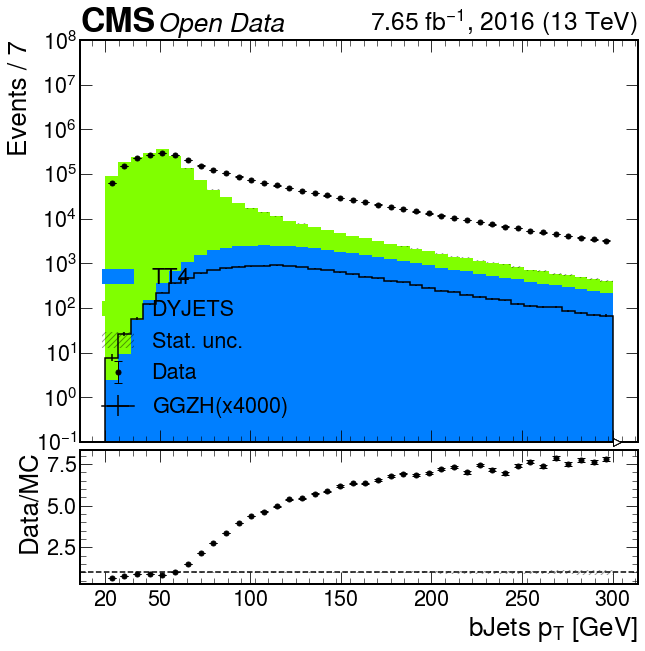

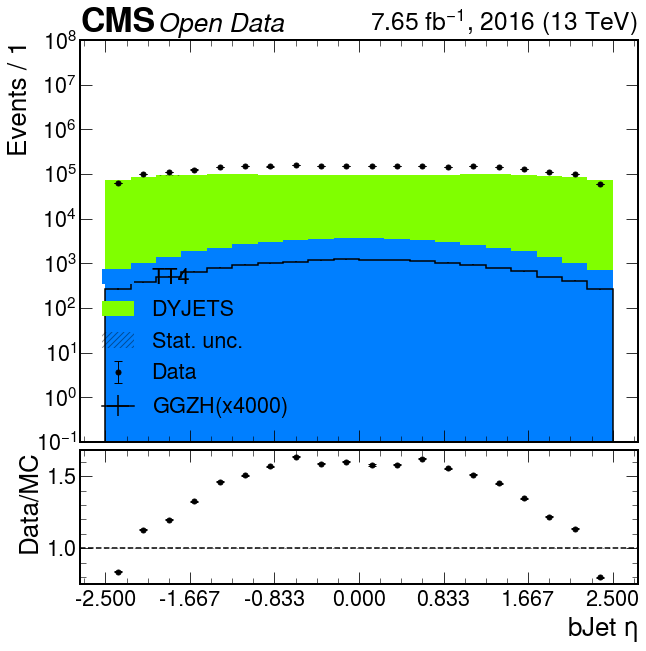

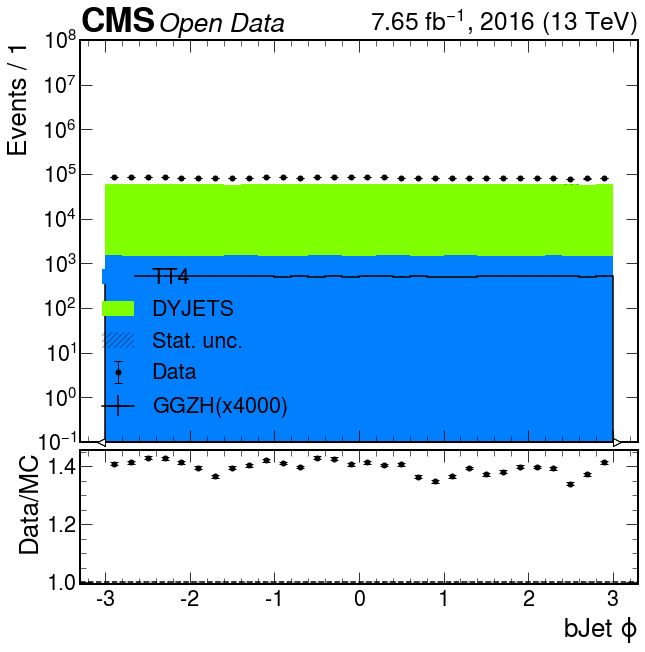

In [51]:
import os
import time

import hist
import json
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import ratio_uncertainty
import matplotlib as mpl
import numpy as np
import pickle
from collections import OrderedDict 

#---------------------Plotting function with CMS style
def plotHisto( thehist, thebkgs, histName = "jets_pt", xlabel = "bJets $p_{T}$ [GeV]", rebinFactor = 7, 
                  xmin = 20j, xmax = 300j, mcFactor = 1, xlog=False):

    data = thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "data", "nominal"]
    hists = [] 
    tot = data.copy()
    tot.reset()

    for ibkg in thebkgs:
        hists.append( (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"]) )
        tot += (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"])
        
    #note that the signal dataset name is harcoded here
    signal = 4000*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "GGZH", "nominal"]
        
    fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.03), sharex=True)
    #the labels are harcoded and it is for 2015
    hep.cms.label("Open Data", ax=ax, data=True, lumi=7.65, year=2016) #, rlabel="2.3 $\mathrm{fb^{-1}}$, 2015 (8 TeV)")
    plt.style.use(hep.style.CMS)

    hep.histplot(data, ax=ax, histtype='errorbar', color='k', capsize=4, yerr=True, label="Data")
    hep.histplot(hists, ax=ax, stack=True, histtype='fill', color=bkgs_colors, label=bkgs)
    hep.histplot(signal, ax=ax, histtype='step', color='black', label="$ GGZH (x4000) $")

    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.4}
    ax.stairs(
        values=tot.values() + np.sqrt(tot.values()),
        baseline=tot.values() - np.sqrt(tot.values()),
        edges=data.axes[0].edges, **errps, label='Stat. unc.')
    ax.set_yscale("log")
    ax.set_ylim(0.1, 1e5)
    ax.legend()
    ax.set_ylabel(f"Events / {rebinFactor}")
    
    yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
    rax.stairs(1+yerr[1], edges=tot.axes[0].edges, baseline=1-yerr[0], **errps)
    hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
        ax=rax, histtype='errorbar', color='k', capsize=4, label="Data")
    
    # Set the number of y ticks
    ax.set_yticks([1e-1,1,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
    
    # Set the number of x ticks
    if histName == "jets_pt":
        ax.set_xticks([20, 50, 100, 150, 200, 250, 300])
        
    if histName == "njets":
        ax.set_xticks([4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
                
    if histName == "jets_eta":
        ax.set_xticks(np.linspace(-2.5,2.5,7))
        
    if histName == "jets_phi":
        ax.set_xticks(np.linspace(-3,3,7))
        
    if histName == "htb":
        ax.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])


    rax.axhline(1, ls='--', color='k')
    ### more labels
    plt.xlabel(xlabel)
    plt.ylabel("Data/MC")
    plt.show()
#-----------------------------------

with open("histograms.pkl", "rb") as f:
    h2 = pickle.load(f)
    print(h2)
    print(h2.keys())


    ### list of bkgs to plot
    dictBkgs = OrderedDict()
    #dictBkgs["ttbar"] = { "color" : "#80ff00", "label" : "$t\\bar{t}$" }
    dictBkgs["DYJETS"] = { "color" : "#007fff", "label" : "EW" }
    dictBkgs["TT4"] = { "color" : "#80ff00", "label" : "EW" }
    

    bkgs = list(dictBkgs.keys())[::-1]
    print(bkgs)
    bkgs_colors = [ col["color"] for i, col in dictBkgs.items() ]
    print(bkgs_colors)
    bkgs_label = [ col["label"] for i, col in dictBkgs.items() ]

    #plotHisto(h2,bkgs,rebinFactor = 7,xlog=True)
    #plt.savefig("f1.png")  # Guarda la figura como PDF
    #plt.show()  # Muestra la figura en la pantalla
    #plotHisto(h2,bkgs, histName = "jets_eta", xlabel = "bJet $\\eta$", rebinFactor = 1 ,xlog=True, xmin = -2.5j, xmax = 2.5j)
    #plt.savefig("f2.png")  # Guarda la figura como PDF
    #plt.show()  # Muestra la figura en la pantalla
    #plotHisto(h2,bkgs, histName = "jets_phi", xlabel = "bJet $\\phi$", rebinFactor = 1 ,xlog=True, xmin = -3j, xmax = 3j)
    #plt.savefig("f3.png")  # Guarda la figura como PDF
    #plt.show()  # Muestra la figura en la pantalla
    plotHisto(h2, bkgs, rebinFactor=7, xlog=True)
    plt.savefig("f1.png")  # Guarda la primera figura como PNG
    plt.close()  # Muestra la primera figura en la pantalla

    plotHisto(h2, bkgs, histName="jets_eta", xlabel="bJet $\\eta$", rebinFactor=1, xlog=True, xmin=-2.5j, xmax=2.5j)
    plt.savefig("f2.png")  # Guarda la segunda figura como PNG
    plt.close() # Muestra la segunda figura en la pantalla

    plotHisto(h2, bkgs, histName="jets_phi", xlabel="bJet $\\phi$", rebinFactor=1, xlog=True, xmin=-3j, xmax=3j)
    plt.savefig("f3.png")  # Guarda la tercera figura como PNG
    plt.close()  # Muestra la tercera figura en la pantalla


    #plotHisto(h2,bkgs,xlog=True)

In [ ]:
################ Masa Invariante y DR###############################
####################################################################


In [52]:
import asyncio
import logging
import os
import time

import pickle
import vector; vector.register_awkward() 
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

import pandas as pd



In [53]:
DATA = "DoubleMuon"
NTUPLES = "data/ntuples.json"

## input files per process, set to e.g. 10 (smaller number = faster)
##-1 means use them all
N_FILES_MAX_PER_SAMPLE = 2

## BENCHMARKING-SPECIFIC SETTINGS

## chunk size to use
CHUNKSIZE = 500_000

## metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

## scaling for local setups with FuturesExecutor
NUM_CORES = 4


In [54]:

##NanoAOD datasets are stored in data/ntuples_nanoaod.json folder. 
##This json file contains information about the number of events, 
##process and systematic. The following function reads the 
##json file and returns a dictionary with the process to run.
#--------------------------------------------------
def construct_fileset(n_files_max_per_sample,
                      dataset="DoubleMuon",
                      onlyNominal=False,
                      ntuples_json=NTUPLES):
    ## Cross sections are in pb
    ## These numbers have been artificially manipulated
    ## to make the example plot coincide
    ## Xsections need to be correct and the backgrounds
    ## properly normalized
    xsec_info = {
    #    "ttbar": 831., 
    #    "wjets": 61526, 
    #    "tttt" : 0.009, 
    #    "dyjets": 6025,
    #    "ttbar": 831./200., 
        "TT4": 88.29, 
        "GGZH" : 0.00784, 
        "DYJETS": 5343.0*1.23,
        "data": None
    }

    ## list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)
    
    ## process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            file_list = file_info[process][dataset]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples

            file_paths = [f["path"] for f in file_list]
            metadata = {"process": "data", "xsec": 1}
            fileset.update({"data": {"files": file_paths, "metadata": metadata}})
            
        ##these "variations" are used for systematic studies
        ##A simple example would use only "nominal"
        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            #print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample] #use partial set

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

    return fileset
#--------------------------------------------------    



In [55]:


##-------------Build the filesets
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, dataset=DATA,
                            onlyNominal=True, ntuples_json=NTUPLES) 
##informational printouts
#print(fileset["ttbar__nominal"]["metadata"])
print(fileset["GGZH__nominal"]["metadata"])
print(fileset["TT4__nominal"]["metadata"])
print(fileset["DYJETS__nominal"]["metadata"])
print(fileset["data"]["metadata"])
print(f"\nExample information in fileset:\n{{\n  'files': [{fileset['data']['files'][:]}]\n")
##----------------------------------------------------------


{'process': 'GGZH', 'variation': 'nominal', 'nevts': 76000, 'xsec': 0.00784}
{'process': 'TT4', 'variation': 'nominal', 'nevts': 454000, 'xsec': 88.29}
{'process': 'DYJETS', 'variation': 'nominal', 'nevts': 2610309, 'xsec': 6571.89}
{'process': 'data', 'xsec': 1}

Example information in fileset:
{
  'files': [['file:data/2631F9B1-3B3E-7E4A-BE75-FC57E322C981.root', 'file:data/26A77DF8-54A5-7B44-B1BB-5B93CFF5C9C6.root']]



In [56]:
##---------------------------------------------------------
## This part is useful to check the total number of
## data events.  We will need to scale things properly later
## Load the JSON file
with open(NTUPLES, 'r') as file:
    data = json.load(file)
    #print(type(data))

## Initialize a variable to store the total number of events
total_events = 0

In [57]:
## Loop through the files in the JSON data
for file_info in data['data']['DoubleMuon']['files']:
    file_path = file_info['path']
    #print(file_path)

    ## Open the ROOT file using uproot
    with uproot.open(file_path) as f:
        ## Access the 'events' TTree and count the number of entries (events)
        num_events = f['Events'].num_entries

        ## Print the file path and number of events
        print("Real data dataset info:")
        print(f"File: {file_path}, Number of Events: {num_events}")

        ## Add the number of events to the total
        total_events += num_events

## Print the total number of events
print(f"Total Number of Events: {total_events}\n")
#-----------------------------------

Real data dataset info:
File: file:data/2631F9B1-3B3E-7E4A-BE75-FC57E322C981.root, Number of Events: 1477455
Real data dataset info:
File: file:data/26A77DF8-54A5-7B44-B1BB-5B93CFF5C9C6.root, Number of Events: 1659527
Total Number of Events: 3136982



In [58]:
##------------------------------------------------------Analyzer
##Here is the main analyzer. Uses coffea/awkward to make the analysis.
class TemplateAnalysis(processor.ProcessorABC):
    def __init__(self, DATASET):
        self.DATASET = DATASET
        # booking histograms
        # define categories
        # Take a look at 
        # https://cms-opendata-workshop.github.io/workshop2023-lesson-ttbarljetsanalysis/03-coffea-analysis/index.html#histogramming-and-plotting
        process_cat = hist.axis.StrCategory([], name="process", label="Process", growth=True)
        variation_cat  = hist.axis.StrCategory([], name="variation", label="Systematic variation", growth=True)
        ## define bins (axis)
        pt_axis = hist.axis.Regular( bins=500, start=0, stop=500, name="var")
        eta_axis = hist.axis.Regular( bins=40, start=-5, stop=5, name="var")
        phi_axis = hist.axis.Regular( bins=40, start=-4, stop=4, name="var")
        num_axis = hist.axis.Regular( bins=20, start=0, stop=20, name="var") 
        R_axis = hist.axis.Regular( bins=20, start=0, stop=8, name="var")
        mass_axis = hist.axis.Regular( bins=20, start=0, stop=150, name="var")
        
        # define a dictionary of histograms
        # here is an example of a few variables that one might want to save for later and produce pretty plots
        # this, and most of the stuff here, will have to be tailored to the specifics of each analysis 
        self.hist_muon_dict = {
            #'muon_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'muon_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'nmuons'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_pt'  : (hist.Hist(pt_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_eta' : (hist.Hist(eta_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_phi' : (hist.Hist(phi_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            #'njets'    : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())), 
            'nbjets'   : (hist.Hist(num_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_R' : (hist.Hist(R_axis, process_cat, variation_cat, storage=hist.storage.Weight())),
            'jets_mass' : (hist.Hist(mass_axis, process_cat, variation_cat, storage=hist.storage.Weight()))
        }
        
        # I think this might have to go
        # In principle sumw comes from ROOT's sumw(sum weight) function, but I do not know what it does here.
        sumw_dict = {'sumw': processor.defaultdict_accumulator(float)
        }
         
        
        ### define vector lists for scatter plot
        self.njets_signal_data = []
        self.njets_background_data = []
        self.nbjets_signal_data = []
        self.nbjets_background_data = []
        self.njets_values=[]
        self.nbjets_values=[]
        self.njets_data = []
        self.nbjets_data = []

    #------This process function is the one that
    # is run when the object of this class are forced to "run"
    def process(self, events):
        hists = self.hist_muon_dict.copy()
        # this refers to the type of dataset.  Do not confuse the process variable
        # here, with the name of the function:
        process = events.metadata["process"]
        #print(events.fields)

        #print(f'Working on process: {process}')
        #print(f'The dataset is {events.metadata["dataset"]}')
  
        if process != "data":
            # normalization for MC
            x_sec = events.metadata["xsec"]
            nevts_total = events.metadata["nevts"]
            # the luminosity has to be calculated and scaled appropiately
            # this number is hardcoded here
            lumi = 7.653261227*1000*3136982/45235604 # /pb integrated luminosity
            xsec_weight = x_sec * lumi / nevts_total #L*cross-section/N
        else:
            xsec_weight = 1


        #------------------Event Selection
        # Filtering of the data can be done essentially at two levels:
        # at the event level and the physical object level
        # Here are a few lines (mostly commented out) showcasing how one
        # could apply event selection requirements.
        # There could be a lot more event selection cuts that need to 
        # be applied, depending on the analysis
        
        #Require that the primary vertex in the event is good
        #primary_vertex= events.PV.npvsGood == True
        
        ## Requirement on number of primary vertex.
        ## Require at least one
        # 4 grados de libertad
        #a radial position within 2 cm of the beamspot axis
        
        primary_vertex = (events.PV.npvs >= 1) & (events.PV.z <= 24) & (np.sqrt(events.PV.x**2 + events.PV.y**2) <= 2) & (events.PV.ndof > 4)
        
        ##Trigger selection        
        #event_filters = ( events.HLT.IsoMu20 == 1 )
        
        #update event_filters container
        #event_filters = event_filters & primary_vertex
        event_filters=primary_vertex
        selected_events = events[event_filters]
        #--------------------------------------------------------------------------


        ##---------------------------------------Object selection
        ## This is selection that applies to specific physics objects, like muons, jets, b-jets, etc.
        ## Here are a few examples, mostly commented out for the sake of getting some statistics
        ## from a very low number of events.

        ## Note the use of masks in order to apply certain requirements
        #muon_is_global= events.Muon.isGlobal == True
        #muon_is_tracker= events.Muon.isTracker == True
        
        ## Note that this could be all replaced by Tight, Medium or Loose flags, that should be
        ## operative in 2016 nanoado production
        ## we have reduced the requirements just to get more events
        ## The selection, however, needs to align to what the papers describe for the corresponding analysis
        #loose_muon_selection = (events.Muon.pt > 10) & (abs(events.Muon.eta)<2.5) \
        #                        & ((muon_is_global) | (muon_is_tracker)) \
        #                        & (events.Muon.pfRelIso04_all < 0.25)
        # selected_muon_selection = (events.Muon.pt > 26) & (abs(events.Muon.eta)<2.1) \
        #                             & ((muon_is_global) & (muon_is_tracker)) \
        #                             & (events.Muon.nTrackerLayers > 5) & (events.Muon.nStations > 0) \
        #                             & (abs(events.Muon.dxy) < 0.2) & (abs(events.Muon.dz) < 0.5) \
        #                             & (events.Muon.pfRelIso04_all < .15)
        ## Note that the selection is done using the masks above
        ## This is how filtering is done in the industry as well
        #selected_muons = events.Muon[( loose_muon_selection & selected_muon_selection)]
        #veto_muons = events.Muon[( loose_muon_selection & ~selected_muon_selection)]
        #selected_muons = events.Muon[(events.Muon.pt > 5)]
        #selected_muon = (ak.count(selected_muons.pt, axis=1) == 1 ) 

        
        ## Selection of jets
        
        #jet_selection = (ak.count(jets_selection.pt, axis=1) == 1 )
        #selected_jets = events.Jet[jet_selection]
        ## Note here that some functions and tools are already implemented as part of coffea, like the TLorentzVector's nearest()
        ## See: https://github.com/CoffeaTeam/coffea/blob/d3beaff974025aa260efb2df9e8da7138a77b795/src/coffea/nanoevents/methods/vector.py#L779
        ## and the coffea documentation
        #nearest_lepton = selected_jets.nearest(selected_muons, threshold=.4)
        #selected_jets = selected_jets[ ~ak.is_none(nearest_lepton) ]
        ## the results of these 2 lines should be equivalent to the 2 lines above
        #lepton_mask = ak.any(selected_jets.metric_table(selected_lepton, metric=lambda j, e: ak.local_index(j, axis=1) == e.jetIdx,), axis=2)
        #selected_jets = selected_jets[~lepton_mask]
        ##this is an example of how b-jets might be selected
        #selected_bjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & (events.Jet.btagCSVV2 >=0.8)]
        #selected_jets_nobjets = events.Jet[jet_selection & ~ak.is_none(nearest_lepton) & ~(events.Jet.btagCSVV2 >=0.8)]
    
        jets_selection = (events.Jet.pt > 20) & (abs(events.Jet.eta) < 2.5) & (events.Jet.jetId > 1)
        
        #selected_jets = events.Jet[(jets_selection)]
        #selected_jet=(ak.count(selected_jets.pt, axis=1) == 1 )
        
        ###Filtro Btag    
        #selected_bjets = events.Jet[jets_selection & (events.Jet.btagCSVV2 >=0.8)]
        selected_bjets = events.Jet[jets_selection]
        #selected_bjet=(ak.count(selected_bjets.pt, axis=1) == 1 )
        
        ## Electron selection
        ##Veto electrons 
        #veto_electron_selection = (events.Electron.pt > 15) & (abs(events.Electron.eta) < 2.5) & (events.Electron.cutBased == 1)    
        ##tight electrons
        #selected_electron_selection = (events.Electron.pt > 30) & (abs(events.Electron.eta) < 2.1) & (events.Electron.cutBased == 4)
        #selected_electrons = events.Electron[ selected_electron_selection & veto_electron_selection]
        #veto_electrons = events.Electron[ veto_electron_selection ]
        #selected_electrons = events.Electron[(events.Electron.pt > 3)]        
        
        ## Additional selection
        ## Exactly zero additional loose muons
        #veto_muon = (ak.count(veto_muons.pt, axis=1 ) == 0 )
        #event_filters = event_filters & veto_muon
        ##Exactly zero veto electrons
        #veto_electron = (ak.count(veto_electrons.pt, axis=1) == 0 )      
        #event_filters = event_filters & veto_electron
        ## At least 6 jets
        #at_least_one_jet = (ak.count(selected_jets.pt, axis=1) >= 6)
        #event_filters = event_filters & at_least_one_jet
        
        ## At least 2 bjets
        selected_bjet = (ak.count(selected_bjets.pt, axis=1) >= 2)        
        event_filters = event_filters & selected_bjet
        #print(event_filters)
        
        ##overwrite the event filter just to get
        ##more statistics
        #event_filters = selected_bjet
        selected_events = events[event_filters]
        #selected_muons = selected_muons[event_filters]
        
        #selected_jets = selected_jets[event_filters]
        selected_bjets = selected_bjets[event_filters]
        
        #selected_electrons = selected_electrons[event_filters]
               
        
        
        #--------------------------------------------------------------------------


        ##------------------Mass and DR
        #Iterative filters once the events are selected with the object selection
        
        #opposing_charges = (selected_muons.charge[:,0] * selected_muons.charge[:,1] < 0)
        
        
        ##---------------------------------------Joint Properties
        #Joint arguments
        system_product_pt = selected_bjets[:,0].pt * selected_bjets[:,1].pt
        system_cosh_eta = np.cosh(selected_bjets[:,0].eta - selected_bjets[:,1].eta)
        system_cos_phi = np.cos(selected_bjets[:,0].phi - selected_bjets[:,1].phi)
        
        #Relative Distance
        
        delta_phi = selected_bjets[:,0].phi - selected_bjets[:,1].phi
        delta_eta = selected_bjets[:,0].eta - selected_bjets[:,1].eta
        
        delta_R = np.sqrt(delta_phi**2 + delta_eta**2)
        
        #Invariant Mass
        
        system_invariant_mass = np.sqrt(2 * system_product_pt * (system_cosh_eta - system_cos_phi))
        
        #Fill the histograms
        
        hists['jets_R'].fill(var=delta_R, process=process, variation="nominal", weight=xsec_weight)
        hists['jets_mass'].fill(var=system_invariant_mass, process=process, variation="nominal", weight=xsec_weight)
        
        hists['nbjets'].fill(var=ak.count(selected_bjets.pt, axis=0), process=process, variation="nominal", weight=xsec_weight)
        
        jets_values = ak.count(selected_bjets.pt, axis=0)
        
        output = {"nevents": {events.metadata["dataset"]: len(selected_events)}, "hists" : hists,
                  "nbjets_signal_data": self.nbjets_signal_data,
                  "nbjets_background_data": self.nbjets_background_data,
                  "nbjets_data": self.nbjets_data
                 }           
        return output

    def postprocess(self, accumulator):        
        return accumulator
#--------------------------------------------    

 

In [59]:
#--------------------------------------------
# Run the executor
# The iterative executor is a local, simple executor
# The FuturesExecutor manages threads in a more efficient way
#executor = processor.FuturesExecutor()
executor = processor.IterativeExecutor()

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)
t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=TemplateAnalysis(DATASET=DATA))
exec_time = time.monotonic() - t0
#--------------------------------------------
    

#----------------------------------------------------------------------
# Now, we extract the data that we will later use
nevents_info = all_histograms["nevents"]
for dataset, num_events in nevents_info.items():
    print(f"Dataset: {dataset}, Number of Events: {num_events}")
    
nbjsig = all_histograms["nbjets_signal_data"]
nbjbkg = all_histograms["nbjets_background_data"]
nbjdata = all_histograms["nbjets_data"]
# njsig = all_histograms["njets_signal_data"]
# njbkg = all_histograms["njets_background_data"]
# nbjsig = all_histograms["nbjets_signal_data"]
# nbjbkg = all_histograms["nbjets_background_data"]
# njdata = all_histograms["njets_data"]
# nbjdata = all_histograms["nbjets_data"]

#save histograms in pkl file
with open("histograms.pkl", "wb") as f: 
    pickle.dump(all_histograms["hists"], f, protocol=pickle.HIGHEST_PROTOCOL)

#this is just bookeeping
dataset_source = "/data" if fileset["TT4__nominal"]["files"][0].startswith("/data") else "other"
metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE})
print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717

/usr/local/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Dataset: DYJETS__nominal, Number of Events: 1359593
Dataset: TT4__nominal, Number of Events: 453826
Dataset: GGZH__nominal, Number of Events: 73410
Dataset: data, Number of Events: 2605809
event rate per worker (full execution time divided by NUM_CORES=4): 15.95 kHz
event rate per worker (pure processtime): 193.65 kHz
amount of data read: 216.76 MB


{'jets_pt': Hist(
  Regular(500, 0, 500, name='var'),
  StrCategory([], growth=True, name='process', label='Process'),
  StrCategory([], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'jets_eta': Hist(
  Regular(40, -5, 5, name='var'),
  StrCategory([], growth=True, name='process', label='Process'),
  StrCategory([], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'jets_phi': Hist(
  Regular(40, -4, 4, name='var'),
  StrCategory([], growth=True, name='process', label='Process'),
  StrCategory([], growth=True, name='variation', label='Systematic variation'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0), 'nbjets': Hist(
  Regular(20, 0, 20, name='var'),
  StrCategory(['DYJETS', 'TT4', 'GGZH', 'data'], growth=True, name='process', label='Process'),
  StrCategory(['nominal'], growth=True, name='variation', label='Systematic va

/tmp/ipykernel_17/2692084852.py:51: RuntimeWarning: invalid value encountered in divide
  hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
/usr/local/venv/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/venv/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<Figure size 720x720 with 0 Axes>

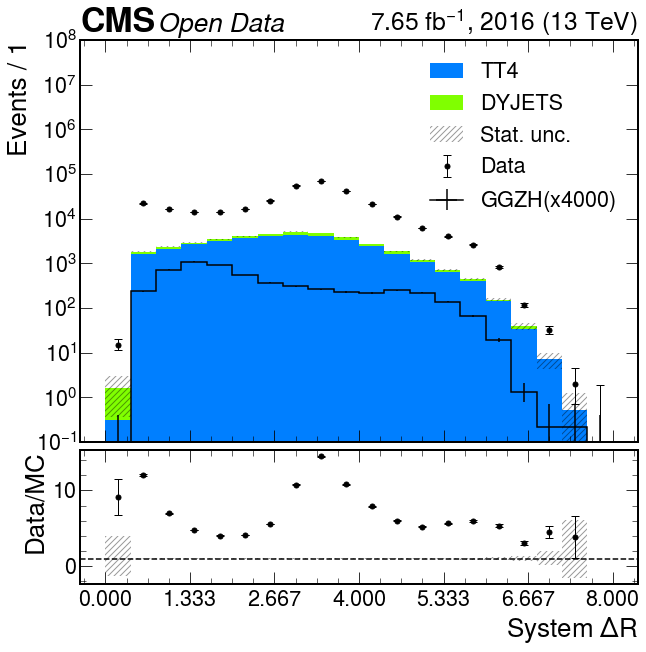

/tmp/ipykernel_17/2692084852.py:51: RuntimeWarning: invalid value encountered in divide
  hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
/usr/local/venv/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/venv/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


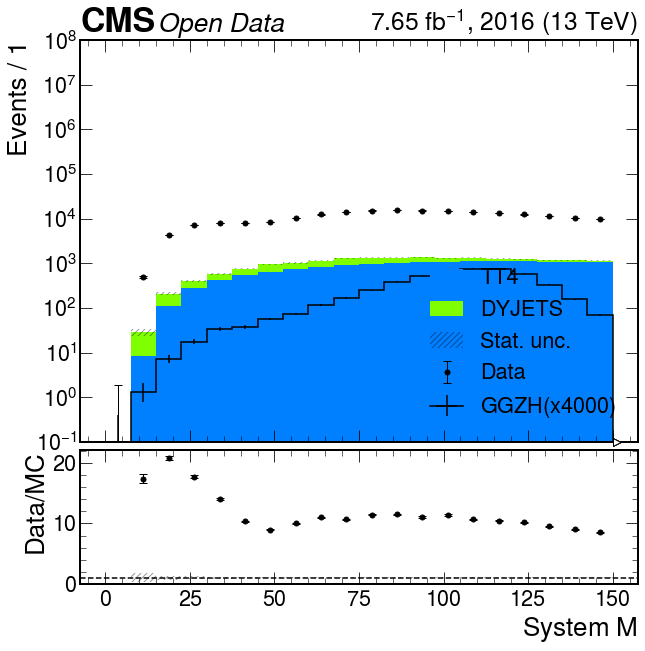

In [48]:
import os
import time

import hist
import json
import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import ratio_uncertainty
import matplotlib as mpl
import numpy as np
import pickle
from collections import OrderedDict 

#---------------------Plotting function with CMS style
def plotHisto( thehist, thebkgs, histName = "jets_pt", xlabel = "bJets $p_{T}$ [GeV]", rebinFactor = 7, 
                  xmin = 20j, xmax = 300j, mcFactor = 1, xlog=False):

    data = thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "data", "nominal"]
    hists = [] 
    tot = data.copy()
    tot.reset()

    for ibkg in thebkgs:
        hists.append( (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"]) )
        tot += (mcFactor*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), ibkg, "nominal"])
        
    #note that the signal dataset name is harcoded here
    signal = 4000*thehist[histName][ xmin:xmax:hist.rebin(rebinFactor), "GGZH", "nominal"]
        
    fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0.03), sharex=True)
    #the labels are harcoded and it is for 2015
    hep.cms.label("Open Data", ax=ax, data=True, lumi=7.65, year=2016) #, rlabel="2.3 $\mathrm{fb^{-1}}$, 2015 (8 TeV)")
    plt.style.use(hep.style.CMS)

    hep.histplot(data, ax=ax, histtype='errorbar', color='k', capsize=4, yerr=True, label="Data")
    hep.histplot(hists, ax=ax, stack=True, histtype='fill', color=bkgs_colors, label=bkgs)
    hep.histplot(signal, ax=ax, histtype='step', color='black', label="$ GGZH (x4000) $")

    errps = {'hatch':'////', 'facecolor':'none', 'lw': 0, 'color': 'k', 'alpha': 0.4}
    ax.stairs(
        values=tot.values() + np.sqrt(tot.values()),
        baseline=tot.values() - np.sqrt(tot.values()),
        edges=data.axes[0].edges, **errps, label='Stat. unc.')
    ax.set_yscale("log")
    ax.set_ylim(0.1, 1e5)
    ax.legend()
    ax.set_ylabel(f"Events / {rebinFactor}")
    
    yerr = ratio_uncertainty(data.values(), tot.values(), 'poisson')
    rax.stairs(1+yerr[1], edges=tot.axes[0].edges, baseline=1-yerr[0], **errps)
    hep.histplot(data.values()/tot.values(), tot.axes[0].edges, yerr=np.sqrt(data.values())/tot.values(),
        ax=rax, histtype='errorbar', color='k', capsize=4, label="Data")
    
    # Set the number of y ticks
    ax.set_yticks([1e-1,1,1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8])
    
    # Set the number of x ticks
    if histName == "jets_pt":
        ax.set_xticks([20, 50, 100, 150, 200, 250, 300])
        
    if histName == "njets":
        ax.set_xticks([4,5,6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
                
    if histName == "jets_eta":
        ax.set_xticks(np.linspace(-2.5,2.5,7))
        
    if histName == "jets_phi":
        ax.set_xticks(np.linspace(-3,3,7))
    
    if histName == "jets_R":
        ax.set_xticks(np.linspace(0,8,7))
        
    if histName == "jets_mass":
        ax.set_xticks(np.linspace(0,150,7))
        
    if histName == "htb":
        ax.set_xticks([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])


    rax.axhline(1, ls='--', color='k')
    ### more labels
    plt.xlabel(xlabel)
    plt.ylabel("Data/MC")
    plt.show()
#-----------------------------------

with open("histograms.pkl", "rb") as f:
    h2 = pickle.load(f)
    print(h2)
    print(h2.keys())


    ### list of bkgs to plot
    dictBkgs = OrderedDict()
    #dictBkgs["ttbar"] = { "color" : "#80ff00", "label" : "$t\\bar{t}$" }
    
    dictBkgs["DYJETS"] = { "color" : "#007fff", "label" : "EW" }
    dictBkgs["TT4"] = { "color" : "#80ff00", "label" : "EW" }
    
    bkgs = list(dictBkgs.keys())[::-1]
    print(bkgs)
    bkgs_colors = [ col["color"] for i, col in dictBkgs.items() ]
    print(bkgs_colors)
    bkgs_label = [ col["label"] for i, col in dictBkgs.items() ]

    #plotHisto(h2,bkgs,rebinFactor = 7,xlog=True)
    #plotHisto(h2,bkgs, histName = "jets_eta", xlabel = "bJet $\\eta$", rebinFactor = 1 ,xlog=True, xmin = -2.5j, xmax = 2.5j)
    #plotHisto(h2,bkgs, histName = "jets_phi", xlabel = "bJet $\\phi$", rebinFactor = 1 ,xlog=True, xmin = -3j, xmax = 3j)

    
    plt.savefig("nombredelafigura.png")
    plotHisto(h2, bkgs, histName = "jets_R", xlabel = "System $\\Delta R$", rebinFactor = 1, xlog=True, xmin = 0j, xmax = 8j)
    plotHisto(h2, bkgs, histName = "jets_mass", xlabel = "System $M$", rebinFactor = 1, xlog=True, xmin = 0j, xmax = 150j)
        #plotHisto(h2,bkgs,xlog=True)